<a href="https://colab.research.google.com/github/ttderessa/Temesgen-Deressa/blob/main/Comparing_Four_Machine_Learning_Models_for_Loan_Default_Prediction_with_Boosting_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparing Four Machine Learning Models for Loan Default Prediction with Boosting Methods: A Comprehensive Analysis with Visual Summaries

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Number of positive: 7898, number of negative: 89586
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3481
[LightGBM] [Info] Number of data points in the train set: 97484, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081018 -> initscore=-2.428589
[LightGBM] [Info] Start training from score -2.428589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division

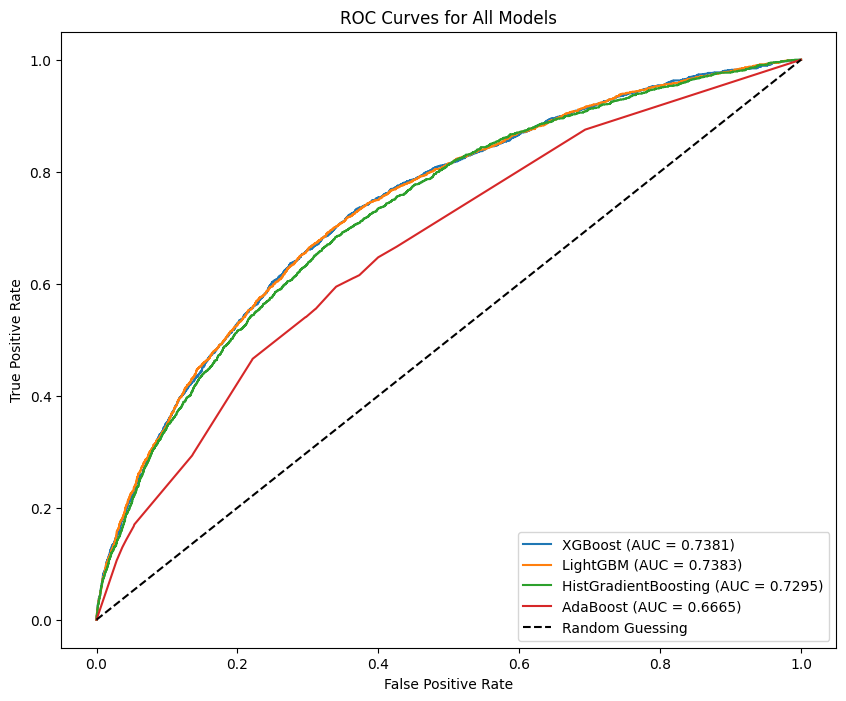


Model Accuracy and AUC Comparison:
                      Accuracy     AUC
XGBoost                 0.9202  0.7381
LightGBM                0.9206  0.7383
HistGradientBoosting    0.9204  0.7295
AdaBoost                0.9201  0.6665



Classification Report for XGBoost:
              precision    recall  f1-score       support
0              0.920710  0.999376  0.958431  22425.000000
1              0.548387  0.008731  0.017189   1947.000000
accuracy       0.920236  0.920236  0.920236      0.920236
macro avg      0.734549  0.504054  0.487810  24372.000000
weighted avg   0.890966  0.920236  0.883239  24372.000000



Classification Report for LightGBM:
              precision    recall  f1-score       support
0              0.920915  0.999599  0.958645  22425.000000
1              0.709677  0.011299  0.022245   1947.000000
accuracy       0.920647  0.920647  0.920647      0.920647
macro avg      0.815296  0.505449  0.490445  24372.000000
weighted avg   0.904040  0.920647  0.883839  24372.000

<Figure size 1000x600 with 0 Axes>

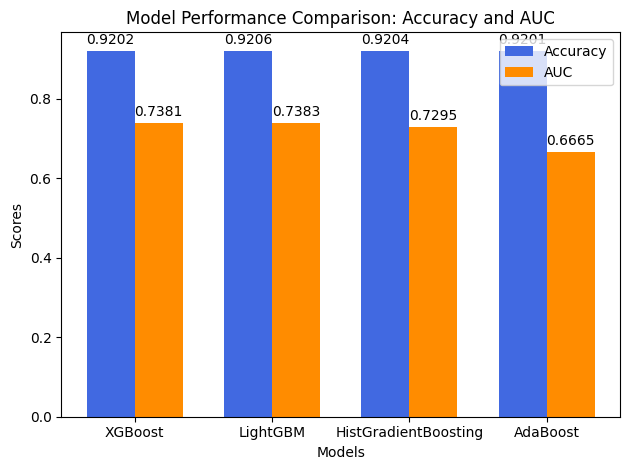

In [1]:
# Data processing libraries
import pandas as pd
import numpy as np

# Model selection and evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    roc_curve,
    auc,
    confusion_matrix
)

# Machine learning models
from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load data with memory optimization
dtype_dict = {
    'Column1': 'float32',  # Replace with actual column names and types
    'Column2': 'int8',     # Example of numeric columns
    # Add other columns here if you know their data types to optimize memory usage
}

# Use low_memory=False to prevent pandas from trying to load data in chunks
df = pd.read_csv('AutoCredit.csv', dtype=dtype_dict, low_memory=False)

# Handle non-numeric columns, e.g., remove currency symbols and convert to numeric
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].replace({'\$': '', ',': ''}, regex=True)  # Remove symbols like '$'

# Convert all columns to numeric (if possible)
df = df.apply(pd.to_numeric, errors='coerce')

# Handle missing values in the target column and features
df = df.dropna(subset=['Default'])  # Ensure the target is not missing

# Preprocessing - Handle missing values in features using SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Separate features and target variable
X = df.drop('Default', axis=1)
y = df['Default']

# Identify numeric columns for imputation (skip non-numeric columns)
numeric_columns = X.select_dtypes(include=[np.number]).columns
X_numeric = X[numeric_columns]

# Apply imputer only to numeric columns with valid data
X_numeric_valid = X_numeric.loc[:, X_numeric.isnull().mean() < 1]  # Keep only columns with some valid data
X_imputed_numeric = imputer.fit_transform(X_numeric_valid)

# Create DataFrame from imputed values
X_imputed = pd.DataFrame(X_imputed_numeric, columns=X_numeric_valid.columns)

# Identify non-numeric columns and apply One-Hot Encoding
X_non_numeric = X.drop(columns=numeric_columns)
X_imputed_combined = pd.concat([X_imputed, X_non_numeric], axis=1)
categorical_columns = X_imputed_combined.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X_imputed_combined, columns=categorical_columns, drop_first=True)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Model list
models = {
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'HistGradientBoosting': HistGradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier()
}

# Hyperparameter grid for RandomizedSearchCV
param_dist = {
    'XGBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'LightGBM': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'HistGradientBoosting': {
        'max_iter': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'AdaBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1]
    }
}

# Function for model comparison
def model_comparison(X_train, y_train, X_test, y_test):
    accuracy_results = {}
    auc_results = {}
    reports = {}

    plt.figure(figsize=(10, 8))
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        random_search = RandomizedSearchCV(
            estimator=model, param_distributions=param_dist[model_name],
            n_iter=5, cv=3, random_state=42, n_jobs=2
        )
        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_

        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]

        accuracy_results[model_name] = round(accuracy_score(y_test, y_pred), 4)
        auc_results[model_name] = round(roc_auc_score(y_test, y_pred_proba), 4)
        reports[model_name] = classification_report(y_test, y_pred, output_dict=True)

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models')
    plt.legend(loc="lower right")
    plt.show()  # Add space after the ROC curves plot

    return accuracy_results, auc_results, reports

# Run model comparison
accuracy_results, auc_results, reports = model_comparison(X_train, y_train, X_test, y_test)

# Create DataFrame for comparison
results_df = pd.DataFrame({
    'Accuracy': accuracy_results,
    'AUC': auc_results
})

print("\nModel Accuracy and AUC Comparison:")
print(results_df)
print("\n")  # Add space after table output

# Display classification reports
for model_name, report in reports.items():
    print(f"\nClassification Report for {model_name}:")
    print(pd.DataFrame(report).T)
    print("\n")  # Add space after each classification report table

# Plot the performance summary
plt.figure(figsize=(10, 6))
x = np.arange(len(results_df))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, results_df['Accuracy'], width, label='Accuracy', color='royalblue')
bars2 = ax.bar(x + width/2, results_df['AUC'], width, label='AUC', color='darkorange')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison: Accuracy and AUC')
ax.set_xticks(x)
ax.set_xticklabels(results_df.index)
ax.legend()

# Add text values on bars
def add_values(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom')

add_values(bars1)
add_values(bars2)

plt.tight_layout()
plt.show()  # Add space after bar chart
